# Importação e tratamento dos dados

In [ ]:
# ARIMA MODEL
# file "<stdin>", line 1: type "> realod window" and fixes the problem

# Importar Bibliotecas
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os

# Leitura e tratamento dos dados
owid_co2 = pd.read_csv(r'owid-co2-data.csv')

# Criando index em formato de data
owid_co2.index = pd.to_datetime(owid_co2['year'], format='%Y')

# Separando somente os dados do Brasil
owid_brasil = owid_co2[owid_co2['country'] == 'Brazil']

# Selecionando somente a coluna de emissão de CO2
owid_brasil = owid_brasil[['consumption_co2']]

# Retirar valores nulos

owid_brasil = owid_brasil.dropna()

owid_brasil

<ipython-input-2-05de5a9e0d10>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


,consumption_co2
year,
1990-01-01,245.447
1991-01-01,251.937
1992-01-01,253.867
1993-01-01,262.488
1994-01-01,275.863
1995-01-01,298.736
1996-01-01,321.985
1997-01-01,342.538
1998-01-01,349.415


# Análise Exploratória dos Dados

In [ ]:
# Métricas acerca dos dados
## Estatísticas descritivas
owid_brasil.describe()

,consumption_co2
count,32.000000
mean,397.502750
std,104.260713
min,245.447000
25%,329.714000
50%,354.753500
75%,479.954000
max,612.322000


In [ ]:
## Verificar a presença de valores nulos
print('valores nulos:', owid_brasil.isnull().sum())

valores nulos: consumption_co2    0
dtype: int64


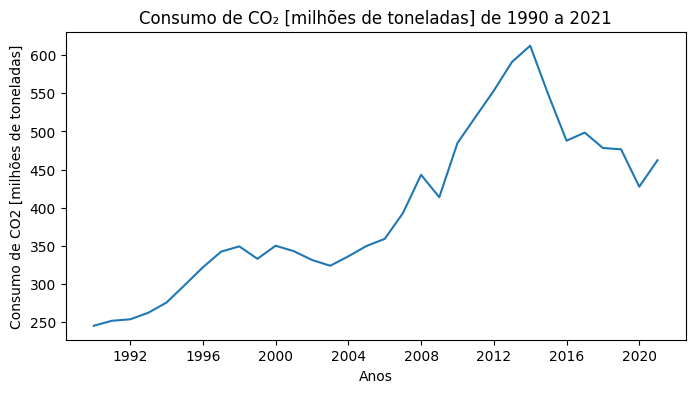

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico da emissão de CO2 ao longo dos anos de análise
fig1 = plt.figure(figsize=(8, 4))
plt.plot(owid_brasil)
plt.xlabel('Anos')
plt.ylabel('Consumo de CO2 [milhões de toneladas]')
plt.title('Consumo de CO₂ [milhões de toneladas] de 1990 a 2021')

# não aparenta possuir sazonalidade já que não existem padrões que se repetem ao longo dos anos

plt.show()
plt.savefig("consumoco2br.png")

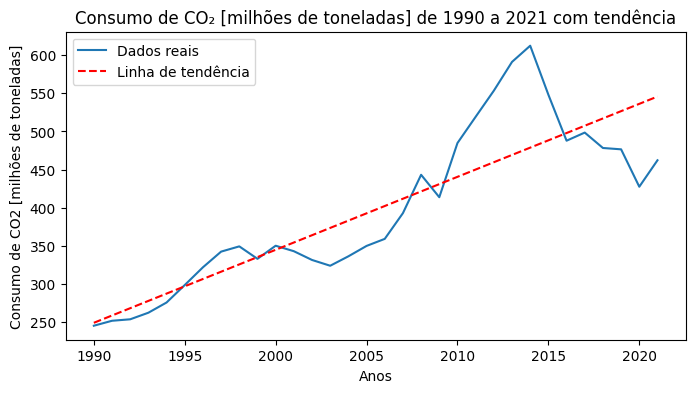

In [ ]:
# Convertendo o índice para valores numéricos
anos_numericos = owid_brasil.index.year.astype(int)

# Gráfico com tendência
fig1_2 = plt.figure(figsize=(8, 4))
plt.plot(anos_numericos, owid_brasil['consumption_co2'], label='Dados reais')
plt.xlabel('Anos')
plt.ylabel('Consumo de CO2 [milhões de toneladas]')
plt.title('Consumo de CO₂ [milhões de toneladas] de 1990 a 2021 com tendência')

# Adicionando a linha de tendência
z = np.polyfit(anos_numericos, owid_brasil['consumption_co2'], 1)
p = np.poly1d(z)
plt.plot(anos_numericos, p(anos_numericos), "r--", label='Linha de tendência')

plt.legend()  # Adiciona a legenda com base nos labels fornecidos
plt.show()
fig1_2.savefig("consumotrendbr.png")


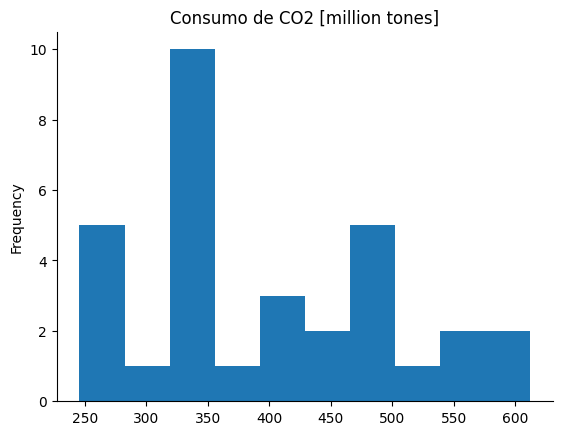

In [ ]:
from matplotlib import pyplot as plt
owid_brasil['consumption_co2'].plot(kind='hist', title='Consumo de CO2 [million tones]')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.savefig("consumoco2br_hist.png")

In [ ]:
# Teste de sazonalidade
from scipy import stats

## CHECANDO PARA SAZONALIDADE ANUAL
res = []

for i in owid_brasil.index.unique():
    res.append(owid_brasil.loc[i, 'consumption_co2'])

result = stats.kruskal(*res)

if result[1] > 0.05:
  print("Não há sazonalidade")
else:
  print("Há sazonalidade")
print(result)

Não há sazonalidade
KruskalResult(statistic=31.0, pvalue=0.46621250621750804)


Como o teste de **Kruskal-Wallis** indicou um p-value de 0.466, maior que o nível de significância de 5%. Dessa forma, não existe sazonalidade entre os anos de análise (1991-2021).

TypeError: float() argument must be a string or a real number, not 'DecomposeResult'

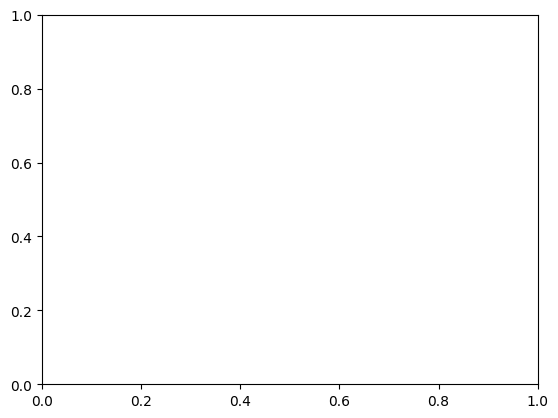

In [ ]:
from statsmodels.tsa import seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
data_decompose = seasonal_decompose(owid_brasil['consumption_co2'], model = 'multiplicable', period = 1)
#plt.plot(data_decompose)

**Rule of thumb**

O modelo pode ser aditivo ou multiplicativo. Se a variação da tendência e variância são relativamente constantes ao longo do tempo, é aditivo. No caso contrário, tendência e variância aumentam ou diminuem ao longo do tempo, é um modelo multiplicativo.

In [ ]:
# Verificação de estacionariedade
## Teste Dickey-Fuller aumentado
import statsmodels
from statsmodels.tsa.stattools import adfuller

# Parâmetros escolhidos
autolag_escolhido = 'AIC'

# Função para o teste de dickey-fuller aumentado
def adfuller_test(df, autolag_escolhido):
  # Null hypothesis: Non Stationarity exists in the series (raiz única)
  # Alternative Hypothesis: Stationarity exists in the series

  adfuller_test = adfuller(df, autolag = autolag_escolhido)

  if adfuller_test[1]<=0.05:
    print('Série temporal estacionária com p-value igual a:', adfuller_test[1])
  else:
    print('Série temporal não-estacionária com p-value igual a:', adfuller_test[1])
  return adfuller_test

# Aplicação da função
adfuller_test(owid_brasil, autolag_escolhido)


Série temporal não-estacionária com p-value igual a: 0.5989309621076846


(-1.3650103386304664,
 0.5989309621076846,
 0,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 211.37349619878586)

# P-value do teste de Dickey-fuller aumentado

p-value é a probabilidade da hipótese nula não ser rejeitada. Se p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. Se p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Como o p-value está acima de 0,05 (ou 5%), a hipótese nula não pode ser rejeitada: **a série é não-estacionária**.

In [ ]:
# Realizando a diferenciação para torná-la estacionária

owid_brasil_diff1 = owid_brasil.diff().dropna()

# Aplicação do adfuller novamente para verificar estacionariedade:
adfuller_test(owid_brasil_diff1, autolag_escolhido)

Série temporal estacionária com p-value igual a: 0.0002913816641085193


(-4.404546151725183,
 0.0002913816641085193,
 0,
 30,
 {'1%': -3.6699197407407405,
  '5%': -2.9640707407407407,
  '10%': -2.621171111111111},
 212.40714123495684)

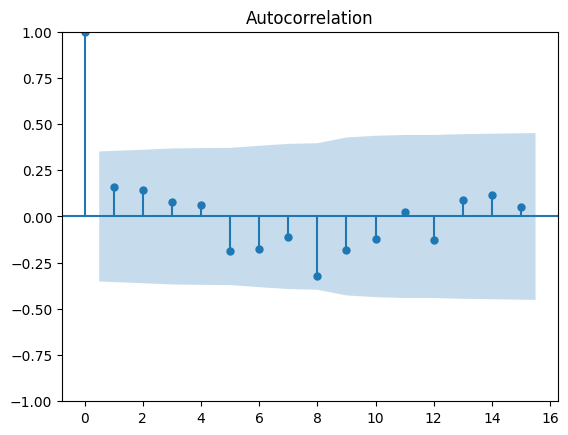

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Autocorrelação ACF (ou FAC) (q)

plot_acf(owid_brasil_diff1)

# Última observação significativa (q) é 0
plt.savefig("fac_diff1.png")

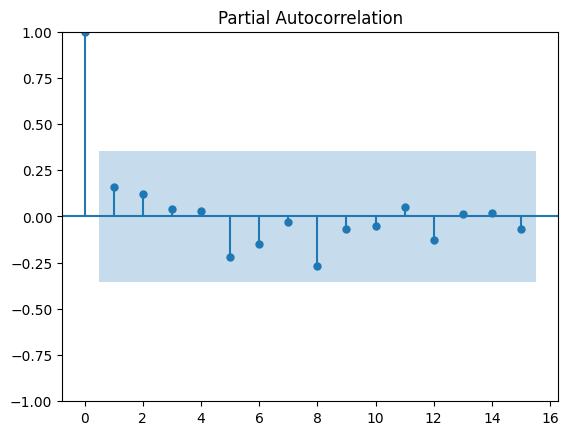

In [ ]:
# Autocorrelação parcial PACF ou FACP (p)
plot_pacf(owid_brasil_diff1)

# Última observação significativa (p) é 0
plt.savefig("facp_diff1.png")

Conforme o gráfico de autocorrelação (FAC), a última observação significativa é 0. Dessa forma, o parâmetro "q" do modelo ARIMA é 0. Já em relação a Autocorrelação Parcial (FACP), a última observação significativa também é 0. Portanto, o parâmetro "p" é 0.

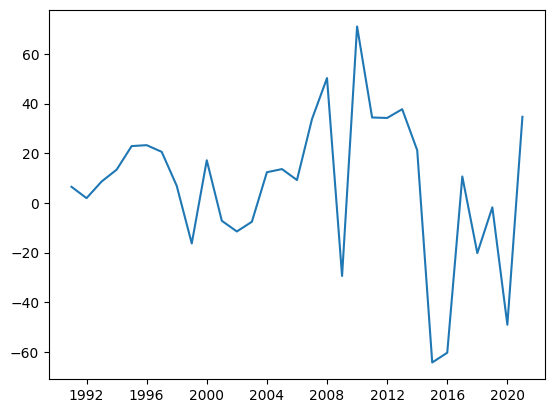

In [ ]:
# Série temporal estacionária (média 0)
plt.plot(owid_brasil_diff1)
plt.savefig("estacionariedade_diff1.png")

In [ ]:
import statsmodels
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p,d,q)
model = ARIMA(owid_brasil, order=(0,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        consumption_co2   No. Observations:                   32
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -149.875
Date:                Thu, 01 Feb 2024   AIC                            301.751
Time:                        16:16:59   BIC                            303.185
Sample:                    01-01-1990   HQIC                           302.218
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       926.5813    240.973      3.845      0.000     454.284    1398.879
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.34   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Análise dos resíduos
O **teste Ljung-Box (L1) (Q)** testa se os resíduos são independentes, ou seja, são **ruído branco**. A probabilidade Q Prob(Q) está acima de 0,05 e, portanto, não é possível rejeitar a hipótese nula de que os erros são ruído branco.

A **heterocedasticidade** testa se os resíduos possuem a mesma variância. A Prob(H) é de 0,01 e, portanto, é menor que 0,05. Dessa forma, rejeita-se a hipótese nula de que os resíduos são homocedásticos. Ou seja, os resíduos apresentam variância.

O **teste Jarque-Bera (JB)** testa a normalidade dos erros. Como Prob(JB) de 0.37 é maior que o p-value de 0.05, a hipótese nula não é rejeitada. Dessa forma, considera-se a normalidade dos resíduos.

Fonte: [How to Interpret ARIMA Results](https://analyzingalpha.com/interpret-arima-results#3_Review_Assumptions)

In [ ]:
from statsmodels.tsa.arima.model import ARIMAResults
# Análise dos resíduos
residuals = pd.DataFrame(model_fit.resid)
residuals.describe()

# Homocedasticidade
model_fit.test_heteroskedasticity('breakvar')

array([[6.23454919, 0.00781681]])

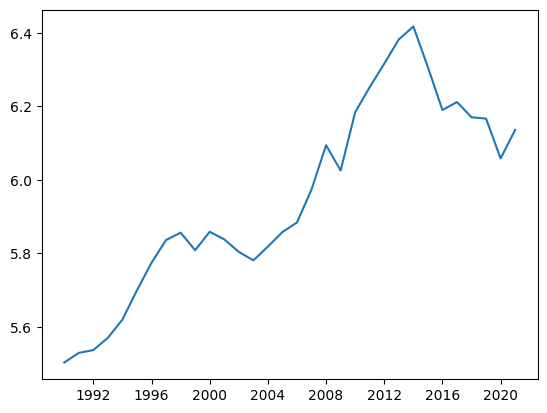

In [ ]:
import math
owid_brasil_log = []
for i in range(len(owid_brasil)):
  owid_brasil_log = np.log(owid_brasil['consumption_co2'])
plt.plot(owid_brasil_log)
plt.savefig("consumoco2br_log.png")

In [ ]:
print(owid_brasil_log)

year
1990-01-01    5.503081
1991-01-01    5.529179
1992-01-01    5.536811
1993-01-01    5.570205
1994-01-01    5.619904
1995-01-01    5.699560
1996-01-01    5.774505
1997-01-01    5.836383
1998-01-01    5.856260
1999-01-01    5.808470
2000-01-01    5.858713
2001-01-01    5.837978
2002-01-01    5.803954
2003-01-01    5.780842
2004-01-01    5.818268
2005-01-01    5.857965
2006-01-01    5.883974
2007-01-01    5.973723
2008-01-01    6.094028
2009-01-01    6.025443
2010-01-01    6.183784
2011-01-01    6.252310
2012-01-01    6.316077
2013-01-01    6.382017
2014-01-01    6.417258
2015-01-01    6.306523
2016-01-01    6.190051
2017-01-01    6.211632
2018-01-01    6.170303
2019-01-01    6.166604
2020-01-01    6.058104
2021-01-01    6.136047
Name: consumption_co2, dtype: float64


In [ ]:
# Verificando estacionariedade
adfuller_test(owid_brasil_log, autolag_escolhido)

Série temporal não-estacionária com p-value igual a: 0.4692958130766715


(-1.6265524403967304,
 0.4692958130766715,
 0,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 -47.30033872864519)

In [ ]:
# Diferenciando uma vez
owid_brasil_log_diff1 = owid_brasil_log.diff().dropna()

# Verificando estacionariedade
adfuller_test(owid_brasil_log_diff1, autolag_escolhido)

Série temporal estacionária com p-value igual a: 0.00020010703889899426


(-4.495797256154057,
 0.00020010703889899426,
 0,
 30,
 {'1%': -3.6699197407407405,
  '5%': -2.9640707407407407,
  '10%': -2.621171111111111},
 -46.074262206174026)

Após uma diferenciação, a série tornou-se estacionária. Dessa forma, é possível aplicar o modelo ARIMA com d = 1.

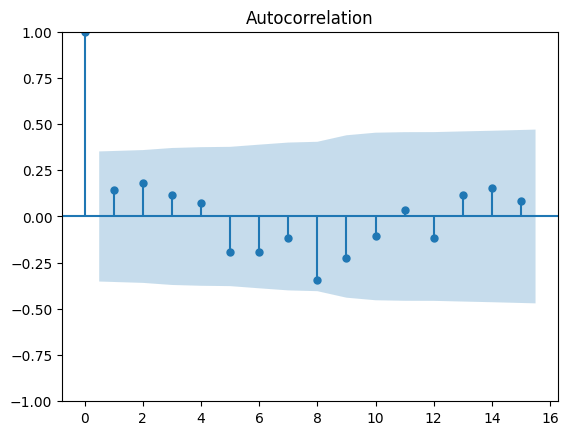

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Autocorrelação ACF (ou FAC) (q)
plot_acf(owid_brasil_log_diff1)

# última observação significativa: 0
plt.savefig("fac_log_diff1.png")

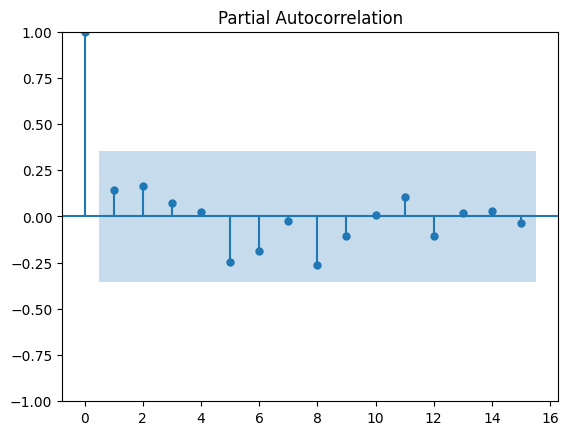

In [ ]:
# Autocorrelação Parcial PACF (ou FACP) (q)
plot_pacf(owid_brasil_log_diff1)
plt.savefig("facp_log_diff1.png")
# última observação significativa: 0

In [ ]:
# ARIMA(p,d,q)
model = ARIMA(owid_brasil_log, order=(0,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        consumption_co2   No. Observations:                   32
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  39.320
Date:                Thu, 01 Feb 2024   AIC                            -76.639
Time:                        14:11:25   BIC                            -75.205
Sample:                    01-01-1990   HQIC                           -76.172
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0046      0.001      3.318      0.001       0.002       0.007
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.40   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


# Análise dos resíduos
O **teste Ljung-Box (L1) (Q)** testa se os resíduos são independentes, ou seja, são **ruído branco**. A probabilidade Q Prob(Q) está acima de 0,05 e, portanto, não é possível rejeitar a hipótese nula de que os erros são ruído branco.

A **heterocedasticidade** testa se os resíduos possuem a mesma variância. A Prob(H) é de 0,23 e, portanto, é maior que 0,05. Dessa forma, não rejeita-se a hipótese nula de que os resíduos são homocedásticos. Ou seja, os resíduos não apresentam variância.

O **teste Jarque-Bera (JB)** testa a normalidade dos erros. Como Prob(JB) de 0.62 é maior que o p-value de 0.05, a hipótese nula não é rejeitada. Dessa forma, considera-se a normalidade dos resíduos.

Fonte: [How to Interpret ARIMA Results](https://analyzingalpha.com/interpret-arima-results#3_Review_Assumptions)

# Previsão do Modelo

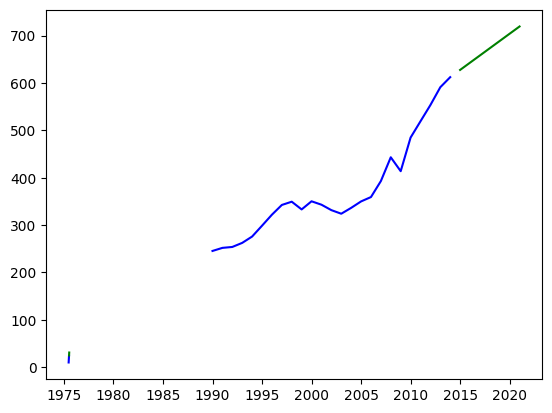

In [ ]:
# Pacotes necessários
##!pip install pmdarima

import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = owid_brasil['consumption_co2']
train, test = train_test_split(y, train_size=25)

# Fit your model
model = pm.auto_arima(train, seasonal=False)
print(model.summary())
# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(anos_numericos[10:25], x[10:25], train, c='blue')
plt.plot(anos_numericos[25:], x[25:], forecasts, c='green')
plt.show()

In [ ]:
y

year
1990-01-01    245.447
1991-01-01    251.937
1992-01-01    253.867
1993-01-01    262.488
1994-01-01    275.863
1995-01-01    298.736
1996-01-01    321.985
1997-01-01    342.538
1998-01-01    349.415
1999-01-01    333.109
2000-01-01    350.273
2001-01-01    343.085
2002-01-01    331.608
2003-01-01    324.032
2004-01-01    336.389
2005-01-01    350.011
2006-01-01    359.234
2007-01-01    392.966
2008-01-01    443.203
2009-01-01    413.825
2010-01-01    484.823
2011-01-01    519.211
2012-01-01    553.398
2013-01-01    591.119
2014-01-01    612.322
2015-01-01    548.136
2016-01-01    487.871
2017-01-01    498.514
2018-01-01    478.331
2019-01-01    476.565
2020-01-01    427.564
2021-01-01    462.223
Name: consumption_co2, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# evaluate forecasts
mape = mean_absolute_percentage_error(test, forecasts)
print('Test MAPE: %.3f' % mape)

Test MAPE: 0.406


In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
arima_automatico = auto_arima(owid_brasil_log)
arima_automatico.summary()